# End-to-End Architecture Performance Comparisons

In [1]:
# System imports
import os
import sys
from pprint import pprint as pp
from time import time as tt
import inspect
import importlib

# External imports
import matplotlib.pyplot as plt
import matplotlib.colors
import scipy as sp
from sklearn.decomposition import PCA
from sklearn.metrics import auc
import numpy as np
import pandas as pd
import seaborn as sns
import torch
from torch_geometric.data import DataLoader
from mpl_toolkits.mplot3d import Axes3D

from itertools import chain

from torch.nn import Linear
import torch.nn.functional as F
from torch_scatter import scatter, segment_csr, scatter_add
from torch_geometric.nn.conv import MessagePassing
from torch_cluster import knn_graph, radius_graph
import trackml.dataset
import torch_geometric
from itertools import permutations

import ipywidgets as widgets
from ipywidgets import interact, interact_manual

from sklearn.cluster import DBSCAN
from sklearn import metrics

# Limit CPU usage on Jupyter
os.environ['OMP_NUM_THREADS'] = '4'

# Pick up local packages
sys.path.append('..')

# Local imports
from prepare_utils import prepare_event
from toy_utils import *
from models import *
from trainers import *
%matplotlib inline

# Get rid of RuntimeWarnings, gross
import warnings
warnings.filterwarnings("ignore", category=RuntimeWarning)
device = 'cuda' if torch.cuda.is_available() else 'cpu'
import wandb
import faiss
props = dict(boxstyle='round', facecolor='wheat', alpha=0.5)
torch_seed = 0

In [2]:
from apex.parallel import DistributedDataParallel as DDP
from apex.fp16_utils import *
from apex import amp, optimizers

In [10]:
importlib.reload(sys.modules['toy_utils'])
from toy_utils import *

In [10]:
importlib.reload(sys.modules['models'])
from models import *

## Data Preparation

### Load & Save Raw Data

Load events:

In [55]:
input_dir = "/global/cscratch1/sd/danieltm/ExaTrkX/trackml/train_all/"
save_dir = "/global/cscratch1/sd/danieltm/ExaTrkX/trackml_processed/"
all_events = os.listdir(input_dir)
all_events = [input_dir + event[:14] for event in all_events]
np.random.shuffle(all_events)

In [56]:
pt_cut = 0.5
train_number = 1000
test_number = 100
basename = os.path.join(save_dir, str(pt_cut) + "_pt_cut")
os.makedirs(basename, exist_ok=True)

In [27]:
%%time
train_dataset = [prepare_event(event_file, pt_cut, [1000, np.pi, 1000], True) for event_file in all_events[:train_number]]
test_dataset = [prepare_event(event_file, pt_cut, [1000, np.pi, 1000], True) for event_file in all_events[-test_number:]]

Preparing /global/cscratch1/sd/danieltm/ExaTrkX/trackml/train_all/event000008103
Preparing /global/cscratch1/sd/danieltm/ExaTrkX/trackml/train_all/event000003521
Preparing /global/cscratch1/sd/danieltm/ExaTrkX/trackml/train_all/event000008528
Preparing /global/cscratch1/sd/danieltm/ExaTrkX/trackml/train_all/event000008498
Preparing /global/cscratch1/sd/danieltm/ExaTrkX/trackml/train_all/event000007255
Preparing /global/cscratch1/sd/danieltm/ExaTrkX/trackml/train_all/event000002461
Preparing /global/cscratch1/sd/danieltm/ExaTrkX/trackml/train_all/event000008676
Preparing /global/cscratch1/sd/danieltm/ExaTrkX/trackml/train_all/event000001494
Preparing /global/cscratch1/sd/danieltm/ExaTrkX/trackml/train_all/event000004281
Preparing /global/cscratch1/sd/danieltm/ExaTrkX/trackml/train_all/event000003996
Preparing /global/cscratch1/sd/danieltm/ExaTrkX/trackml/train_all/event000008383
Preparing /global/cscratch1/sd/danieltm/ExaTrkX/trackml/train_all/event000009217
Preparing /global/cscratch1/

Preparing /global/cscratch1/sd/danieltm/ExaTrkX/trackml/train_all/event000009453
Preparing /global/cscratch1/sd/danieltm/ExaTrkX/trackml/train_all/event000002679
Preparing /global/cscratch1/sd/danieltm/ExaTrkX/trackml/train_all/event000009065
Preparing /global/cscratch1/sd/danieltm/ExaTrkX/trackml/train_all/event000004702
Preparing /global/cscratch1/sd/danieltm/ExaTrkX/trackml/train_all/event000002612
Preparing /global/cscratch1/sd/danieltm/ExaTrkX/trackml/train_all/event000001971
Preparing /global/cscratch1/sd/danieltm/ExaTrkX/trackml/train_all/event000004948
Preparing /global/cscratch1/sd/danieltm/ExaTrkX/trackml/train_all/event000008267
Preparing /global/cscratch1/sd/danieltm/ExaTrkX/trackml/train_all/event000009773
Preparing /global/cscratch1/sd/danieltm/ExaTrkX/trackml/train_all/event000003197
Preparing /global/cscratch1/sd/danieltm/ExaTrkX/trackml/train_all/event000003105
Preparing /global/cscratch1/sd/danieltm/ExaTrkX/trackml/train_all/event000007072
Preparing /global/cscratch1/

Preparing /global/cscratch1/sd/danieltm/ExaTrkX/trackml/train_all/event000004361
Preparing /global/cscratch1/sd/danieltm/ExaTrkX/trackml/train_all/event000006886
Preparing /global/cscratch1/sd/danieltm/ExaTrkX/trackml/train_all/event000005598
Preparing /global/cscratch1/sd/danieltm/ExaTrkX/trackml/train_all/event000006720
Preparing /global/cscratch1/sd/danieltm/ExaTrkX/trackml/train_all/event000004993
Preparing /global/cscratch1/sd/danieltm/ExaTrkX/trackml/train_all/event000001258
Preparing /global/cscratch1/sd/danieltm/ExaTrkX/trackml/train_all/event000008389
Preparing /global/cscratch1/sd/danieltm/ExaTrkX/trackml/train_all/event000009668
Preparing /global/cscratch1/sd/danieltm/ExaTrkX/trackml/train_all/event000001250
Preparing /global/cscratch1/sd/danieltm/ExaTrkX/trackml/train_all/event000008122
Preparing /global/cscratch1/sd/danieltm/ExaTrkX/trackml/train_all/event000004997
Preparing /global/cscratch1/sd/danieltm/ExaTrkX/trackml/train_all/event000009723
Preparing /global/cscratch1/

Preparing /global/cscratch1/sd/danieltm/ExaTrkX/trackml/train_all/event000005280
Preparing /global/cscratch1/sd/danieltm/ExaTrkX/trackml/train_all/event000002823
Preparing /global/cscratch1/sd/danieltm/ExaTrkX/trackml/train_all/event000002605
Preparing /global/cscratch1/sd/danieltm/ExaTrkX/trackml/train_all/event000007290
Preparing /global/cscratch1/sd/danieltm/ExaTrkX/trackml/train_all/event000008259
Preparing /global/cscratch1/sd/danieltm/ExaTrkX/trackml/train_all/event000009325
Preparing /global/cscratch1/sd/danieltm/ExaTrkX/trackml/train_all/event000004206
Preparing /global/cscratch1/sd/danieltm/ExaTrkX/trackml/train_all/event000006122
Preparing /global/cscratch1/sd/danieltm/ExaTrkX/trackml/train_all/event000008994
Preparing /global/cscratch1/sd/danieltm/ExaTrkX/trackml/train_all/event000001533
Preparing /global/cscratch1/sd/danieltm/ExaTrkX/trackml/train_all/event000009434
Preparing /global/cscratch1/sd/danieltm/ExaTrkX/trackml/train_all/event000009873
Preparing /global/cscratch1/

Preparing /global/cscratch1/sd/danieltm/ExaTrkX/trackml/train_all/event000004917
Preparing /global/cscratch1/sd/danieltm/ExaTrkX/trackml/train_all/event000001301
Preparing /global/cscratch1/sd/danieltm/ExaTrkX/trackml/train_all/event000006973
Preparing /global/cscratch1/sd/danieltm/ExaTrkX/trackml/train_all/event000001788
Preparing /global/cscratch1/sd/danieltm/ExaTrkX/trackml/train_all/event000006463
Preparing /global/cscratch1/sd/danieltm/ExaTrkX/trackml/train_all/event000005065
Preparing /global/cscratch1/sd/danieltm/ExaTrkX/trackml/train_all/event000005297
Preparing /global/cscratch1/sd/danieltm/ExaTrkX/trackml/train_all/event000008876
Preparing /global/cscratch1/sd/danieltm/ExaTrkX/trackml/train_all/event000005021
Preparing /global/cscratch1/sd/danieltm/ExaTrkX/trackml/train_all/event000005363
Preparing /global/cscratch1/sd/danieltm/ExaTrkX/trackml/train_all/event000004996
Preparing /global/cscratch1/sd/danieltm/ExaTrkX/trackml/train_all/event000003984
Preparing /global/cscratch1/

Preparing /global/cscratch1/sd/danieltm/ExaTrkX/trackml/train_all/event000006345
Preparing /global/cscratch1/sd/danieltm/ExaTrkX/trackml/train_all/event000006626
Preparing /global/cscratch1/sd/danieltm/ExaTrkX/trackml/train_all/event000001976
Preparing /global/cscratch1/sd/danieltm/ExaTrkX/trackml/train_all/event000003634
Preparing /global/cscratch1/sd/danieltm/ExaTrkX/trackml/train_all/event000009509
Preparing /global/cscratch1/sd/danieltm/ExaTrkX/trackml/train_all/event000001924
Preparing /global/cscratch1/sd/danieltm/ExaTrkX/trackml/train_all/event000001904
Preparing /global/cscratch1/sd/danieltm/ExaTrkX/trackml/train_all/event000006460
Preparing /global/cscratch1/sd/danieltm/ExaTrkX/trackml/train_all/event000004522
Preparing /global/cscratch1/sd/danieltm/ExaTrkX/trackml/train_all/event000002456
Preparing /global/cscratch1/sd/danieltm/ExaTrkX/trackml/train_all/event000005551
Preparing /global/cscratch1/sd/danieltm/ExaTrkX/trackml/train_all/event000009676
Preparing /global/cscratch1/

Preparing /global/cscratch1/sd/danieltm/ExaTrkX/trackml/train_all/event000008557
Preparing /global/cscratch1/sd/danieltm/ExaTrkX/trackml/train_all/event000003437
Preparing /global/cscratch1/sd/danieltm/ExaTrkX/trackml/train_all/event000009712
Preparing /global/cscratch1/sd/danieltm/ExaTrkX/trackml/train_all/event000003269
Preparing /global/cscratch1/sd/danieltm/ExaTrkX/trackml/train_all/event000005434
Preparing /global/cscratch1/sd/danieltm/ExaTrkX/trackml/train_all/event000006038
Preparing /global/cscratch1/sd/danieltm/ExaTrkX/trackml/train_all/event000001512
Preparing /global/cscratch1/sd/danieltm/ExaTrkX/trackml/train_all/event000008288
Preparing /global/cscratch1/sd/danieltm/ExaTrkX/trackml/train_all/event000004082
Preparing /global/cscratch1/sd/danieltm/ExaTrkX/trackml/train_all/event000008028
Preparing /global/cscratch1/sd/danieltm/ExaTrkX/trackml/train_all/event000007521
Preparing /global/cscratch1/sd/danieltm/ExaTrkX/trackml/train_all/event000009370
Preparing /global/cscratch1/

Preparing /global/cscratch1/sd/danieltm/ExaTrkX/trackml/train_all/event000005151
Preparing /global/cscratch1/sd/danieltm/ExaTrkX/trackml/train_all/event000001306
Preparing /global/cscratch1/sd/danieltm/ExaTrkX/trackml/train_all/event000009985
Preparing /global/cscratch1/sd/danieltm/ExaTrkX/trackml/train_all/event000001572
Preparing /global/cscratch1/sd/danieltm/ExaTrkX/trackml/train_all/event000009227
Preparing /global/cscratch1/sd/danieltm/ExaTrkX/trackml/train_all/event000004600
Preparing /global/cscratch1/sd/danieltm/ExaTrkX/trackml/train_all/event000004873
Preparing /global/cscratch1/sd/danieltm/ExaTrkX/trackml/train_all/event000004163
Preparing /global/cscratch1/sd/danieltm/ExaTrkX/trackml/train_all/event000005680
Preparing /global/cscratch1/sd/danieltm/ExaTrkX/trackml/train_all/event000006087
Preparing /global/cscratch1/sd/danieltm/ExaTrkX/trackml/train_all/event000001600
Preparing /global/cscratch1/sd/danieltm/ExaTrkX/trackml/train_all/event000002289
Preparing /global/cscratch1/

Preparing /global/cscratch1/sd/danieltm/ExaTrkX/trackml/train_all/event000003301
Preparing /global/cscratch1/sd/danieltm/ExaTrkX/trackml/train_all/event000004732
Preparing /global/cscratch1/sd/danieltm/ExaTrkX/trackml/train_all/event000005438
Preparing /global/cscratch1/sd/danieltm/ExaTrkX/trackml/train_all/event000003107
Preparing /global/cscratch1/sd/danieltm/ExaTrkX/trackml/train_all/event000009720
Preparing /global/cscratch1/sd/danieltm/ExaTrkX/trackml/train_all/event000001539
Preparing /global/cscratch1/sd/danieltm/ExaTrkX/trackml/train_all/event000009055
Preparing /global/cscratch1/sd/danieltm/ExaTrkX/trackml/train_all/event000005819
Preparing /global/cscratch1/sd/danieltm/ExaTrkX/trackml/train_all/event000006688
Preparing /global/cscratch1/sd/danieltm/ExaTrkX/trackml/train_all/event000005609
Preparing /global/cscratch1/sd/danieltm/ExaTrkX/trackml/train_all/event000003768
Preparing /global/cscratch1/sd/danieltm/ExaTrkX/trackml/train_all/event000008846
Preparing /global/cscratch1/

Preparing /global/cscratch1/sd/danieltm/ExaTrkX/trackml/train_all/event000006757
Preparing /global/cscratch1/sd/danieltm/ExaTrkX/trackml/train_all/event000001183
Preparing /global/cscratch1/sd/danieltm/ExaTrkX/trackml/train_all/event000002589
Preparing /global/cscratch1/sd/danieltm/ExaTrkX/trackml/train_all/event000001825
Preparing /global/cscratch1/sd/danieltm/ExaTrkX/trackml/train_all/event000004169
Preparing /global/cscratch1/sd/danieltm/ExaTrkX/trackml/train_all/event000008903
Preparing /global/cscratch1/sd/danieltm/ExaTrkX/trackml/train_all/event000001674
Preparing /global/cscratch1/sd/danieltm/ExaTrkX/trackml/train_all/event000009811
Preparing /global/cscratch1/sd/danieltm/ExaTrkX/trackml/train_all/event000009694
Preparing /global/cscratch1/sd/danieltm/ExaTrkX/trackml/train_all/event000008140
Preparing /global/cscratch1/sd/danieltm/ExaTrkX/trackml/train_all/event000003982
Preparing /global/cscratch1/sd/danieltm/ExaTrkX/trackml/train_all/event000002668
Preparing /global/cscratch1/

Preparing /global/cscratch1/sd/danieltm/ExaTrkX/trackml/train_all/event000007439
Preparing /global/cscratch1/sd/danieltm/ExaTrkX/trackml/train_all/event000001171
Preparing /global/cscratch1/sd/danieltm/ExaTrkX/trackml/train_all/event000002750
Preparing /global/cscratch1/sd/danieltm/ExaTrkX/trackml/train_all/event000001357
Preparing /global/cscratch1/sd/danieltm/ExaTrkX/trackml/train_all/event000002867
Preparing /global/cscratch1/sd/danieltm/ExaTrkX/trackml/train_all/event000003177
Preparing /global/cscratch1/sd/danieltm/ExaTrkX/trackml/train_all/event000002632
Preparing /global/cscratch1/sd/danieltm/ExaTrkX/trackml/train_all/event000005171
Preparing /global/cscratch1/sd/danieltm/ExaTrkX/trackml/train_all/event000004702
Preparing /global/cscratch1/sd/danieltm/ExaTrkX/trackml/train_all/event000006617
Preparing /global/cscratch1/sd/danieltm/ExaTrkX/trackml/train_all/event000001038
Preparing /global/cscratch1/sd/danieltm/ExaTrkX/trackml/train_all/event000005485
Preparing /global/cscratch1/

In [28]:
with open(os.path.join(basename, str(train_number) + "_events_train"), 'wb') as pickle_file:
#     pickle.dump(train_dataset, pickle_file)
    torch.save(train_dataset, pickle_file)
with open(os.path.join(basename, str(test_number) + "_events_test"), 'wb') as pickle_file:
#     pickle.dump(train_dataset, pickle_file)
    torch.save(test_dataset, pickle_file)

### Load Scrubbed Events

In [2]:
pt_cut = 0.5
train_number = 1000
test_number = 100
load_dir = "/global/cscratch1/sd/danieltm/ExaTrkX/trackml_processed/"
train_path = os.path.join(load_dir, str(pt_cut) + "_pt_cut", str(train_number) + "_events_train")
test_path = os.path.join(load_dir, str(pt_cut) + "_pt_cut", str(test_number) + "_events_test")

In [3]:
%%time 
train_dataset = torch.load(train_path)
test_dataset = torch.load(test_path)
train_loader = DataLoader(train_dataset, batch_size=1, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=1, shuffle=True)

CPU times: user 152 ms, sys: 870 ms, total: 1.02 s
Wall time: 1.26 s


In [8]:
train_dataset[0]

Data(layers=[21007], pid=[21007], true_edges=[20692, 2], x=[21007, 3])

### Model Def

In [44]:
class EdgeNetwork(nn.Module):
    """
    A module which computes weights for edges of the graph.
    For each edge, it selects the associated nodes' features
    and applies some fully-connected network layers with a final
    sigmoid activation.
    """
    def __init__(self, input_dim, nb_layer=4, hidden_dim=8, hidden_activation=torch.nn.Tanh,
                 layer_norm=True):
        super(EdgeNetwork, self).__init__()
        self.network = make_mlp(input_dim*2,
                                [hidden_dim]*nb_layer + [1],
                                hidden_activation=hidden_activation,
                                output_activation=None,
                                layer_norm=layer_norm)

    def forward(self, x, edge_index):
        # Select the features of the associated nodes
        start, end = edge_index
        x1, x2 = x[start], x[end]
        edge_inputs = torch.cat([x[start], x[end]], dim=1)
        return self.network(edge_inputs).squeeze(-1)

class Edge_MLP(nn.Module):
    def __init__(self, in_channels, emb_hidden, nb_layer, emb_dim=3):
        super(Edge_MLP, self).__init__()

        self.input_layer = nn.Linear(in_channels, emb_hidden)
        self.edge_network = EdgeNetwork(emb_hidden, nb_layer, emb_hidden)
        self.final_layer = nn.Linear(emb_hidden, 1)
        self.norm = torch.nn.LayerNorm(emb_hidden)
        
    def forward(self, data):
        x = self.input_layer(data.x)
        x = self.norm(x)
        e = self.edge_network(x, data.e)
        return e

In [45]:
sig = torch.nn.Sigmoid()

def train_filter(model, filter_train_loader, optimizer, m_configs):
    correct = 0
    total = 0
    total_loss = 0
    for i, batch in enumerate(filter_train_loader):
        optimizer.zero_grad()
        data = batch.to(device)
        pred = model(data)
              
        y = batch.pid[batch.e[0]] == batch.pid[batch.e[1]]
                
        loss = F.binary_cross_entropy_with_logits(pred.float(), y.float(), pos_weight=torch.tensor(m_configs["weight"]))
        
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
        
        true, false = y.float() > 0.5, y.float() < 0.5
        positive, negative = sig(pred) > 0.5, sig(pred) < 0.5
        
        correct += ((sig(pred) > 0.5) == (y.float() > 0.5)).sum().item()
        total += true.sum().item()
    acc = correct/total
    return acc, total_loss

def evaluate_filter(model, filter_test_loader, m_configs):
    correct, total_positive, total_true, true_positive, total, total_loss = 0, 1, 0, 0, 0, 0
    
    for batch in filter_test_loader:
        data = batch.to(device)
        pred = model(data)
              
        y = batch.pid[batch.e[0]] == batch.pid[batch.e[1]]
                
        loss = F.binary_cross_entropy_with_logits(pred.float(), y.float(), pos_weight=torch.tensor(m_configs["weight"]))
        total_loss += loss.item()
        
        true, false = y.float() > 0.5, y.float() < 0.5
        positive, negative = sig(pred) > 0.5, sig(pred) < 0.5
        true_positive += (true & positive).sum().item()
        total_positive += max(positive.sum().item(), 1)
        
        correct += ((sig(pred) > 0.5) == (y.float() > 0.5)).sum().item()
        total_true += max(true.sum().item(), 1)
        
#         print("True positive:", (true & positive).sum().item(), "True:", true.sum().item(), "Positive", positive.sum().item())
        
        total += len(pred)

    eff = (true_positive / total_true)
    pur = (true_positive / total_positive)
        
    return eff, pur, total_loss

### Train & Evaluate

In [65]:
m_configs = {"in_channels": 3, "emb_hidden": 128, "nb_layer": 3, "emb_dim": 8}
other_configs = {"weight": 1}
model = Edge_MLP(**m_configs).to(device)
m_configs.update(other_configs)
model_name = wandb.init(project="GravNet", group="AdjacentEmbedding", config=m_configs)
wandb.watch(model, log='all')
optimizer = torch.optim.AdamW(model.parameters(), lr=0.001, weight_decay=1e-3, amsgrad=True)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, factor=0.3, patience=10)

Failed to query for notebook name, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable
wandb: Wandb version 0.9.1 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


In [ ]:
for epoch in range(100):
    tic = tt() 
    model.train()
    pur, train_loss = train_filter(model, filter_train_loader, optimizer, m_configs)
    print('Training loss: {:.4f}'.format(train_loss))

    model.eval()
    with torch.no_grad():
        eff, pur, val_loss = evaluate_filter(model, filter_test_loader, m_configs)
    wandb.log({"val_loss": val_loss, "train_loss": train_loss, "edge_pur": pur, "edge_eff": eff, "lr": optimizer.param_groups[0]['lr']})
    scheduler.step(val_loss)

    save_model(epoch, model, optimizer, scheduler, val_loss, m_configs, 'Embedding/'+model_name._name+'.tar')

    print('Epoch: {}, Eff: {:.4f}, Pur: {:.4f}, Loss: {:.4f}, LR: {} in time {}'.format(epoch, eff, pur, val_loss, optimizer.param_groups[0]['lr'], tt()-tic))

### Results

In [61]:
model.eval()

total_pred = []
total_y = []

for batch in filter_test_loader:
    data = batch.to(device)
    pred = model(data)   
    y = batch.pid[batch.e[0]] == batch.pid[batch.e[1]]

    total_pred += pred.detach().cpu().numpy().tolist()
    total_y += y.cpu().numpy().tolist()

In [62]:
fpr, tpr, _ = metrics.roc_curve(total_y, total_pred)

In [ ]:
list(zip(fpr[tpr>0.99], tpr[tpr>0.99]))

Text(0.5, 1.0, 'Filter over Biadjacent Embedding')

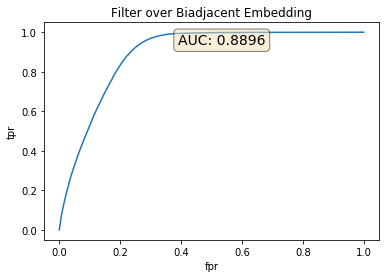

In [63]:
fig, ax = plt.subplots()
ax.plot(fpr, tpr)
ax.text(0.4, 0.95, "AUC: {:.4f}".format(metrics.roc_auc_score(total_y, total_pred)), transform=ax.transAxes, fontsize=14,
        verticalalignment='top', bbox=props)
ax.set_xlabel("fpr"), ax.set_ylabel("tpr")
ax.set_title("Filter over Biadjacent Embedding")

For the case of pT>1GeV, filter doesn't seem to have much effect.

## GNN Edge Classification

### Prepare Edges from Embedding

In [15]:
@torch.no_grad()
def classify_gnn_event(model, batch, r):
    model.eval()
    data = batch.to(device)
    
    spatial = model(data.x)
        
    e_spatial = build_edges(spatial, r, 100, res)
    e_adjacent = e_spatial[:, ((batch.layers[e_spatial[1]] - batch.layers[e_spatial[0]]) == 1)]
    
    e_adjacent = remove_duplicate_edges(data.x.cpu().numpy(), e_adjacent.cpu().numpy()).astype(int)
    y = batch.pid[e_adjacent[0]] == batch.pid[e_adjacent[1]]
    
    data = Data(x = data.x.cpu(), y = y.float().cpu(), emb = spatial.cpu(), pid = data.pid.cpu(), e = torch.from_numpy(e_adjacent).int(), layers = data.layers.cpu(), true_edges = data.true_edges.cpu())
    return data

In [16]:
m_configs = {"in_channels": 3, "emb_hidden": 256, "nb_layer": 6, "emb_dim": 8}
other_configs = {"r_train": 1, "r_val": 1, "margin": 1, 'reduction':'mean'}
torch.manual_seed(torch_seed)
embedding_model = Embedding(**m_configs).to(device)
m_configs.update(other_configs)
checkpoint = torch.load('../model_comparisons/Embedding/dry-puddle-502.tar')
embedding_model.load_state_dict(checkpoint['model_state_dict'])

<All keys matched successfully>

In [17]:
r = 1.8
# step = int((r-r_min)/r_step)
# print(pur[step], eff[step])
# cluster_eff = eff[step]

In [18]:
%%time
gnn_train_dataset = [classify_gnn_event(embedding_model, batch, r=r) for batch in train_loader]
gnn_test_dataset = [classify_gnn_event(embedding_model, batch, r=r) for batch in test_loader]

CPU times: user 1min 28s, sys: 7.26 s, total: 1min 36s
Wall time: 1min 6s


In [19]:
gnn_train_loader = DataLoader(gnn_train_dataset, batch_size=1, shuffle=True)
gnn_test_loader = DataLoader(gnn_test_dataset, batch_size=1, shuffle=True)

In [25]:
del embedding_model
del checkpoint

In [26]:
torch.cuda.empty_cache()
print(torch.cuda.memory_allocated(device=device)/(1024**2), "MB")

0.0 MB


### Load Graph Data

In [7]:
pt_cut = 0
train_number = 1000
test_number = 100
load_dir = "/global/cscratch1/sd/danieltm/ExaTrkX/trackml_processed/"
gnn_train_path = os.path.join(load_dir, str(pt_cut) + "_pt_cut", str(train_number) + "_graphs_train")
gnn_test_path = os.path.join(load_dir, str(pt_cut) + "_pt_cut", str(test_number) + "_graphs_test")

In [8]:
%%time
gnn_train_dataset = torch.load(gnn_train_path)
gnn_test_dataset = torch.load(gnn_test_path)
gnn_train_loader = DataLoader(gnn_train_dataset, batch_size=1, shuffle=True)
gnn_test_loader = DataLoader(gnn_test_dataset, batch_size=1, shuffle=True)

FileNotFoundError: [Errno 2] No such file or directory: '/global/cscratch1/sd/danieltm/ExaTrkX/trackml_processed/0_pt_cut/1000_graphs_train'

In [5]:
def fix_y_batch(batch):
    
    data = Data(x = batch.x, y = batch.y, edge_index = batch.e.long())
    
    return data

In [6]:
%%time
gnn_train_dataset_fix = [fix_y_batch(batch) for batch in gnn_train_dataset]
gnn_test_dataset_fix = [fix_y_batch(batch) for batch in gnn_test_dataset]

CPU times: user 646 ms, sys: 1.21 s, total: 1.86 s
Wall time: 965 ms


In [7]:
%%time
gnn_train_loader = DataLoader(gnn_train_dataset_fix, batch_size=1, shuffle=False, num_workers=4)
gnn_test_loader = DataLoader(gnn_test_dataset_fix, batch_size=1, shuffle=False, num_workers=4)

CPU times: user 23 µs, sys: 37 µs, total: 60 µs
Wall time: 62.5 µs


### Train

New model:

In [13]:
m_configs = {"in_channels": 3, "hidden_dim": 64, "n_graph_iters": 6}
torch.manual_seed(torch_seed)
model = ResAGNN(**m_configs).to(device)
other_configs = {"weight": 2}
m_configs.update(other_configs)
model_name = wandb.init(project="GravNet", group="ResAGNN", config=m_configs)
wandb.watch(model, log='all')
optimizer = torch.optim.AdamW(model.parameters(), lr=0.001, weight_decay=1e-3, amsgrad=True)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, factor=0.3, patience=10)

Failed to query for notebook name, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable
wandb: Wandb version 0.9.1 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


...or load model:

In [14]:
m_configs = {"in_channels": 3, "hidden_dim": 64, "n_graph_iters": 6}
torch.manual_seed(torch_seed)
model = ResAGNN(**m_configs).to(device)
other_configs = {"weight": 2}
m_configs.update(other_configs)
checkpoint = torch.load('../model_comparisons/ResAGNN/ethereal-wood-503.tar')
model.load_state_dict(checkpoint['model_state_dict'])
model_name = wandb.init(project="GravNet", group="ResAGNN", config=m_configs)
wandb.watch(model, log='all')

Failed to query for notebook name, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable
wandb: Wandb version 0.9.1 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


In [15]:
optimizer = torch.optim.AdamW(model.parameters(), lr=0.001, weight_decay=1e-3, amsgrad=True)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, factor=0.3, patience=10)
optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
scheduler.load_state_dict(checkpoint['scheduler_state_dict'])

In [16]:
for epoch in range(100):
    tic = tt()  
    model.train()
    acc, train_loss = train_gnn(model, gnn_train_loader, optimizer, m_configs)
    print("Training loss:", train_loss)

    model.eval()
    with torch.no_grad():
        acc, eff, pur, val_loss = evaluate_gnn(model, gnn_test_loader, m_configs)
    scheduler.step(val_loss)
    wandb.log({"val_loss": val_loss, "train_loss": train_loss, "val_acc": acc, "val_pur": pur, "val_eff": eff, "lr": scheduler._last_lr[0]})

    save_model(epoch, model, optimizer, scheduler, val_loss, m_configs, 'ResAGNN/'+model_name._name+'.tar')

    print('Epoch: {}, Accuracy: {:.4f}, Purity: {:.4f}, Efficiency: {:.4f}, Loss: {:.4f}, LR: {} in time {}'.format(epoch, acc, pur, eff, val_loss, scheduler._last_lr[0], tt()-tic))

Failed to query for notebook name, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable
wandb: Wandb version 0.9.1 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Training loss: 25.063142077997327
Epoch: 0, Accuracy: 0.9929, Purity: 0.9604, Efficiency: 0.9898, Loss: 2.3208, LR: 0.001 in time 211.51566171646118
Training loss: 24.163852674886584
Epoch: 1, Accuracy: 0.9930, Purity: 0.9612, Efficiency: 0.9890, Loss: 2.3506, LR: 0.001 in time 211.6275191307068
Training loss: 23.775235688313842
Epoch: 2, Accuracy: 0.9937, Purity: 0.9663, Efficiency: 0.9894, Loss: 2.1385, LR: 0.001 in time 211.61263060569763
Training loss: 23.52497413009405
Epoch: 3, Accuracy: 0.9879, Purity: 0.9304, Efficiency: 0.9864, Loss: 3.7791, LR: 0.001 in time 211.66961789131165
Training loss: 23.31285702250898
Epoch: 4, Accuracy: 0.9931, Purity: 0.9628, Efficiency: 0.9884, Loss: 2.3456, LR: 0.001 in time 211.37088584899902
Training loss: 23.0078675923869
Epoch: 5, Accuracy: 0.9938, Purity: 0.9652, Efficiency: 0.9910, Loss: 2.0477, LR: 0.001 in time 211.63346529006958
Training loss: 22.563860021531582
Epoch: 6, Accuracy: 0.9934, Purity: 0.9631, Efficiency: 0.9901, Loss: 2.2067,

KeyboardInterrupt: 

Error in callback <function _init_jupyter.<locals>.cleanup at 0x2aab7fe45d40> (for post_run_cell):


KeyboardInterrupt: 

### ROC Results

In [17]:
model.eval()

total_pred = []
total_y = []

for batch in gnn_test_loader:
    data = batch.to(device)
    with torch.no_grad():
        pred = model(data)   
    y = batch.pid[batch.e[0]] == batch.pid[batch.e[1]]

    total_pred += pred.detach().cpu().numpy().tolist()
    total_y += y.cpu().numpy().tolist()

In [18]:
fpr, tpr, _ = metrics.roc_curve(total_y, total_pred)

Text(0.5, 1.0, 'AGNN over Biadjacent Embedding')

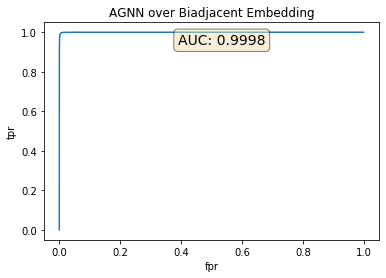

In [19]:
fig, ax = plt.subplots()
ax.plot(fpr, tpr)
ax.text(0.4, 0.95, "AUC: {:.4f}".format(metrics.roc_auc_score(total_y, total_pred)), transform=ax.transAxes, fontsize=14,
        verticalalignment='top', bbox=props)
ax.set_xlabel("fpr"), ax.set_ylabel("tpr")
ax.set_title("AGNN over Biadjacent Embedding")

Text(0.5, 1.0, 'AGNN over Biadjacent Embedding')

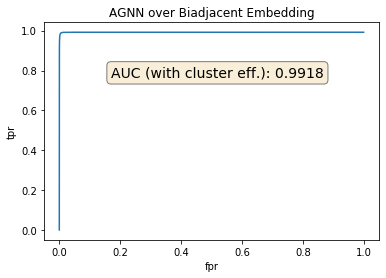

In [20]:
fig, ax = plt.subplots()
ax.plot(fpr, tpr*cluster_eff)
ax.text(0.2, 0.8, "AUC (with cluster eff.): {:.4f}".format(metrics.roc_auc_score(total_y, total_pred)*cluster_eff), transform=ax.transAxes, fontsize=14,
        verticalalignment='top', bbox=props)
ax.set_xlabel("fpr"), ax.set_ylabel("tpr")
ax.set_title("AGNN over Biadjacent Embedding")

### F1 Results

In [124]:
thresh = 0.4
list(zip(fpr[(fpr) > thresh], tpr[fpr > thresh]))

[(0.4455550437586366, 0.9999556613115385),
 (0.445601105481345, 0.9999556613115385),
 (0.45520497466605253, 0.9999556613115385),
 (0.45525103638876097, 0.9999556613115385),
 (0.45794564716720404, 0.9999556613115385),
 (0.4579917088899125, 0.9999556613115385),
 (0.46722708429295257, 0.9999556613115385),
 (0.467273146015661, 0.9999556613115385),
 (0.48224320589590053, 0.9999556613115385),
 (0.48224320589590053, 0.9999704408743589),
 (0.4847305389221557, 0.9999704408743589),
 (0.4847766006448641, 0.9999704408743589),
 (0.49456471672040536, 0.9999704408743589),
 (0.4946107784431138, 0.9999704408743589),
 (0.5251497005988024, 0.9999704408743589),
 (0.5251957623215108, 0.9999704408743589),
 (0.5346614463380931, 0.9999704408743589),
 (0.5347075080608015, 0.9999704408743589),
 (0.5854905573468447, 0.9999704408743589),
 (0.5855366190695532, 0.9999704408743589),
 (0.5894288346384154, 0.9999704408743589),
 (0.5894748963611239, 0.9999704408743589),
 (0.5923767848917549, 0.9999704408743589),
 (0.59

In [21]:
model.eval()

total_pred = []
total_y = []

for batch in gnn_test_loader:
    data = batch.to(device)
    with torch.no_grad():
        pred = model(data)   
    y = batch.pid[batch.e[0]] == batch.pid[batch.e[1]]

    total_pred += sig(pred).detach().cpu().numpy().tolist()
    total_y += y.cpu().numpy().tolist()

Text(0.5, 1.0, 'GNN on Biadjacent Embedding')

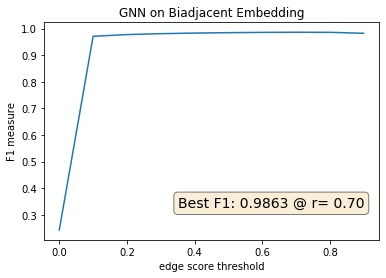

In [27]:
fig, ax = plt.subplots()
f1 = [metrics.f1_score(total_y, np.array(total_pred)>thresh) for thresh in np.arange(0,1,0.1)]
ax.plot(np.arange(0,1,0.1), f1)
ax.text(0.4, 0.2, "Best F1: {:.4f} @ r= {:.2f}".format(max(f1), 0.1*np.argmax(f1)), transform=ax.transAxes, fontsize=14,
        verticalalignment='top', bbox=props)
ax.set_xlabel("edge score threshold"), ax.set_ylabel("F1 measure")
ax.set_title("GNN on Biadjacent Embedding")

## Mixed Precision GNN

In [8]:
class EdgeNetwork(nn.Module):
    """
    A module which computes weights for edges of the graph.
    For each edge, it selects the associated nodes' features
    and applies some fully-connected network layers with a final
    sigmoid activation.
    """
    def __init__(self, input_dim, hidden_dim=8, hidden_activation='Tanh',
                 layer_norm=True):
        super(EdgeNetwork, self).__init__()
        self.network = make_mlp(input_dim*2,
                                [hidden_dim, hidden_dim, hidden_dim, 1],
                                hidden_activation=hidden_activation,
                                output_activation=None,
                                layer_norm=layer_norm)

    def forward(self, x, edge_index):
        # Select the features of the associated nodes
        start, end = edge_index
        x1, x2 = x[start], x[end]
        edge_inputs = torch.cat([x[start], x[end]], dim=1)
        return self.network(edge_inputs).squeeze(-1)

class NodeNetwork(nn.Module):
    """
    A module which computes new node features on the graph.
    For each node, it aggregates the neighbor node features
    (separately on the input and output side), and combines
    them with the node's previous features in a fully-connected
    network to compute the new features.
    """
    def __init__(self, input_dim, output_dim, hidden_activation='Tanh',
                 layer_norm=True):
        super(NodeNetwork, self).__init__()
        self.network = make_mlp(input_dim*3, [output_dim]*4,
                                hidden_activation=hidden_activation,
                                output_activation=None,
                                layer_norm=layer_norm)

    def forward(self, x, e, edge_index):
        start, end = edge_index
        # Aggregate edge-weighted incoming/outgoing features
        mi = scatter_add(e[:, None] * x[start], end, dim=0, dim_size=x.shape[0])
        mo = scatter_add(e[:, None] * x[end], start, dim=0, dim_size=x.shape[0])
        node_inputs = torch.cat([mi, mo, x], dim=1)
        return self.network(node_inputs)
    
class ResAGNN(nn.Module):
    """
    Segment classification graph neural network model.
    Consists of an input network, an edge network, and a node network.
    """
    def __init__(self, in_channels=3, hidden_dim=8, n_graph_iters=3,
                 hidden_activation=torch.nn.Tanh, layer_norm=True):
        super(ResAGNN, self).__init__()
        self.n_graph_iters = n_graph_iters
        # Setup the input network
        self.input_network = make_mlp(in_channels, [hidden_dim],
                                      output_activation=hidden_activation,
                                      layer_norm=layer_norm)
        # Setup the edge network
        self.edge_network = EdgeNetwork(in_channels + hidden_dim, in_channels + hidden_dim,
                                        hidden_activation, layer_norm=layer_norm)
        # Setup the node layers
        self.node_network = NodeNetwork(in_channels + hidden_dim, hidden_dim,
                                        hidden_activation, layer_norm=layer_norm)
#         self.layerNorm = torch.nn.LayerNorm(in_channels + hidden_dim)
        
    def forward(self, x, edge_index):
        """Apply forward pass of the model"""
        x_in = x
#         print(x.shape)
        x = self.input_network(x)
        # Shortcut connect the inputs onto the hidden representation
        x = torch.cat([x, x_in], dim=-1)
        edge_index = edge_index.long()
        # Loop over iterations of edge and node networks
        for i in range(self.n_graph_iters):
            x_inital = x
            
            # Apply edge network
            e = torch.sigmoid(self.edge_network(x, edge_index))
            # Apply node network
            x = self.node_network(x, e, edge_index)
            
            # Shortcut connect the inputs onto the hidden representation
            x = torch.cat([x, x_in], dim=-1)  
            
            x = x_inital + x
            
        return self.edge_network(x, edge_index)

In [9]:
def train_mixed_gnn(model, gnn_train_loader, optimizer, m_configs):
    correct = 0
    total = 0
    total_loss = 0
    data_time, pred_time, loss_time, loss_back_time, optimizer_step = 0, 0, 0, 0, 0
    for i, batch in enumerate(gnn_train_loader):
        optimizer.zero_grad()
        tic = tt()
        data = batch.to(device)
        data_time += tt()-tic
#         print("Edge float", data.e.max().item(), data.e)
#         print("Edge long", data.e.long().max().item(), data.e.long())
#         print("Edge shape", data.e.shape)
        
        tic = tt()
        pred = model(data.x, data.edge_index.int())
        pred_time += tt()-tic
#         print("Pred type", pred.type())
        y = batch.y
#         print("y", np.isnan(y.cpu().detach().numpy()).sum())
#         if (np.isnan(pred.cpu().detach().numpy()).sum() == 0):
        tic = tt()
        loss = F.binary_cross_entropy_with_logits(pred.float(), y, pos_weight=torch.tensor(m_configs["weight"]))
        loss_time += tt()-tic
        tic = tt()
        with amp.scale_loss(loss, optimizer) as scaled_loss:
            scaled_loss.backward()
#         loss.backward()
        loss_back_time += tt()-tic
#         torch.nn.utils.clip_grad_norm_(model.parameters(), m_configs["clip"])
        tic = tt()
        optimizer.step()
        optimizer_step += tt()-tic
        
        total_loss += loss.item()

        true, false = y.float() > 0.5, y.float() < 0.5
        positive, negative = sig(pred) > 0.5, sig(pred) < 0.5

        correct += ((sig(pred) > 0.5) == (y.float() > 0.5)).sum().item()
        total += len(pred)
#         else:
#             print("Broke!")
#         if(i%50==0): print(i, "batches")
        
    acc = correct/max(total, 1)
    print("data_time, pred_time, loss_time, loss_back_time, optimizer_step")
    print(data_time, pred_time, loss_time, loss_back_time, optimizer_step)
    return acc, total_loss

def evaluate_mixed_gnn(model, gnn_test_loader, m_configs):
    correct, total_positive, total_true, true_positive, total, total_loss = 0, 1, 0, 0, 0, 0
    
    for batch in gnn_test_loader:
        data = batch.to(device)
        pred = model(data.x, data.edge_index.int())
              
        y = batch.y

#         print("y", y, "length", len(y))
#         if (np.isnan(pred.cpu().detach().numpy()).sum() == 0):
        loss = F.binary_cross_entropy_with_logits(pred.float(), y.float(), pos_weight=torch.tensor(m_configs["weight"]))
        total_loss += loss.item()

        true, false = y.float() > 0.5, y.float() < 0.5
#         print("true", true, "sum", true.float().sum().item())
        positive, negative = sig(pred) > 0.5, sig(pred) < 0.5
        true_positive += (true & positive).sum().item()
        total_positive += max(positive.sum().item(), 1)

        correct += ((sig(pred) > 0.5) == (y.float() > 0.5)).sum().item()
        total_true += max(true.sum().item(), 1)

#         print("True positive:", (true & positive).sum().item(), "True:", true.sum().item(), "Positive", positive.sum().item())

        total += len(pred)

    acc = correct/max(total, 1)
    eff = (true_positive / max(total_true, 1))
    pur = (true_positive / max(total_positive, 1))
    
#     print("Num total_true:", total_true, "Num total_positive:", total_positive, "Num true_positive:", true_positive, "Total edges:", total)
        
    return acc, eff, pur, total_loss

In [10]:
m_configs = {"in_channels": 3, "hidden_dim": 64, "n_graph_iters": 8}
model = ResAGNN(**m_configs).to(device)
other_configs = {"weight": 3}
torch.manual_seed(torch_seed)
m_configs.update(other_configs)
# model_name = wandb.init(project="PrecisionStudy", group="ResAGNN", config=m_configs)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-3, amsgrad=True)
# optimizer = optimizers.FusedAdam(model.parameters(), lr = 0.001, weight_decay=1e-3)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, factor=0.3, patience=10)
train_loss_vec = []
val_loss_vec = []
val_eff = []
val_pur = []

In [11]:
model, optimizer = amp.initialize(model, optimizer, opt_level="O2", min_loss_scale=1)#, master_weights=False)

Selected optimization level O2:  FP16 training with FP32 batchnorm and FP32 master weights.

Defaults for this optimization level are:
enabled                : True
opt_level              : O2
cast_model_type        : torch.float16
patch_torch_functions  : False
keep_batchnorm_fp32    : True
master_weights         : True
loss_scale             : dynamic
Processing user overrides (additional kwargs that are not None)...
After processing overrides, optimization options are:
enabled                : True
opt_level              : O2
cast_model_type        : torch.float16
patch_torch_functions  : False
keep_batchnorm_fp32    : True
master_weights         : True
loss_scale             : dynamic


In [12]:
# torch.backends.cudnn.benchmark = True
for epoch in range(21):
    tic = tt()  
    model.train()
    acc, train_loss = train_mixed_gnn(model, gnn_train_loader, optimizer, m_configs)
    print("Training loss:", train_loss)

    model.eval()
    with torch.no_grad():
        acc, eff, pur, val_loss = evaluate_mixed_gnn(model, gnn_test_loader, m_configs)
    scheduler.step(val_loss)
#     wandb.log({"val_loss": val_loss, "train_loss": train_loss, "val_acc": acc, "val_pur": pur, "val_eff": eff, "lr": scheduler._last_lr[0]})

#     save_model(epoch, model, optimizer, scheduler, val_loss, m_configs, 'ResAGNN/'+model_name._name+'.tar')
    print("End of epoch mem:", torch.cuda.memory_allocated(device=device)/(1024**2), "MB")
    print('Epoch: {}, Accuracy: {:.4f}, Purity: {:.4f}, Efficiency: {:.4f}, Loss: {:.4f}, LR: {} in time {}'.format(epoch, acc, pur, eff, val_loss, scheduler._last_lr[0], tt()-tic))
    
    train_loss_vec.append(train_loss)
    val_loss_vec.append(val_loss)
    val_eff.append(eff)
    val_pur.append(pur)

Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 32768.0
Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 16384.0
Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 8192.0
Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 4096.0
Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 2048.0
data_time, pred_time, loss_time, loss_back_time, optimizer_step
2.2163429260253906 12.864920854568481 0.2551743984222412 258.436194896698 3.318375825881958
Training loss: 348.9142432510853
End of epoch mem: 0.9072265625 MB
Epoch: 0, Accuracy: 0.9457, Purity: 0.7413, Efficiency: 0.9340, Loss: 17.4979, LR: 0.001 in time 287.09330701828003
data_time, pred_time, loss_time, loss_back_time, optimizer_step
2.3154044151306152 12.24441933631897 0.23364567756652832 258.262330532074 3.3043336868286133
Training loss: 167.22985703498125
End of epoch mem: 0.9072265625 MB
Epoch: 1, Accuracy: 0.9496, Purity: 0.7

In [13]:
np.savez("logs/mixed_precision_wide.np", train_loss_vec, val_loss_vec, val_eff, val_pur)

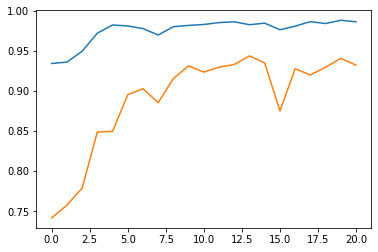

In [14]:
plt.plot(val_eff)
plt.plot(val_pur)

### Compare Mixed vs. Full Precision Performance

In [15]:
full_perf = np.load("logs/full_precision.np.npz")
mixed_perf = np.load("logs/mixed_precision.np.npz")
mixed_perf_wide = np.load("logs/mixed_precision_wide.np.npz")

In [16]:
full_train_loss_vec, full_val_loss_vec, full_val_eff, full_val_pur = full_perf['arr_0'], full_perf['arr_1'], full_perf['arr_2'], full_perf['arr_3']
mixed_train_loss_vec, mixed_val_loss_vec, mixed_val_eff, mixed_val_pur = mixed_perf['arr_0'], mixed_perf['arr_1'], mixed_perf['arr_2'], mixed_perf['arr_3']
mixed_wide_train_loss_vec, mixed_wide_val_loss_vec, mixed_wide_val_eff, mixed_wide_val_pur = mixed_perf_wide['arr_0'], mixed_perf_wide['arr_1'], mixed_perf_wide['arr_2'], mixed_perf_wide['arr_3']

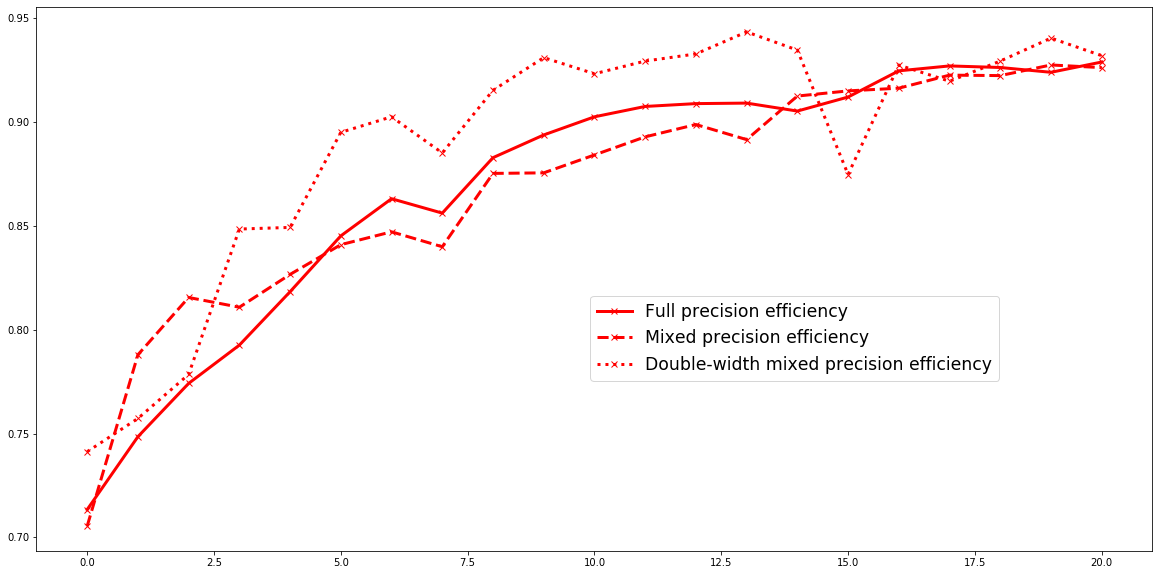

In [32]:
ax = plt.figure(figsize=(20,10))
plt.plot(full_val_eff, 'bx-', linewidth=3)
plt.plot(mixed_val_eff, 'bx--', linewidth=3)
plt.plot(mixed_wide_val_eff, 'bx:', linewidth=3)
plt.plot(full_val_pur, 'rx-', linewidth=3)
plt.plot(mixed_val_pur, 'rx--', linewidth=3)
plt.plot(mixed_wide_val_pur, 'rx:', linewidth=3)
ax.legend(['Full precision efficiency', 'Mixed precision efficiency', 'Double-width mixed precision efficiency', 'Full precision purity', 'Mixed precision purity', 'Double-width mixed precision purity'], bbox_to_anchor=(0.7, 0.4), fontsize='xx-large', fancybox=True)

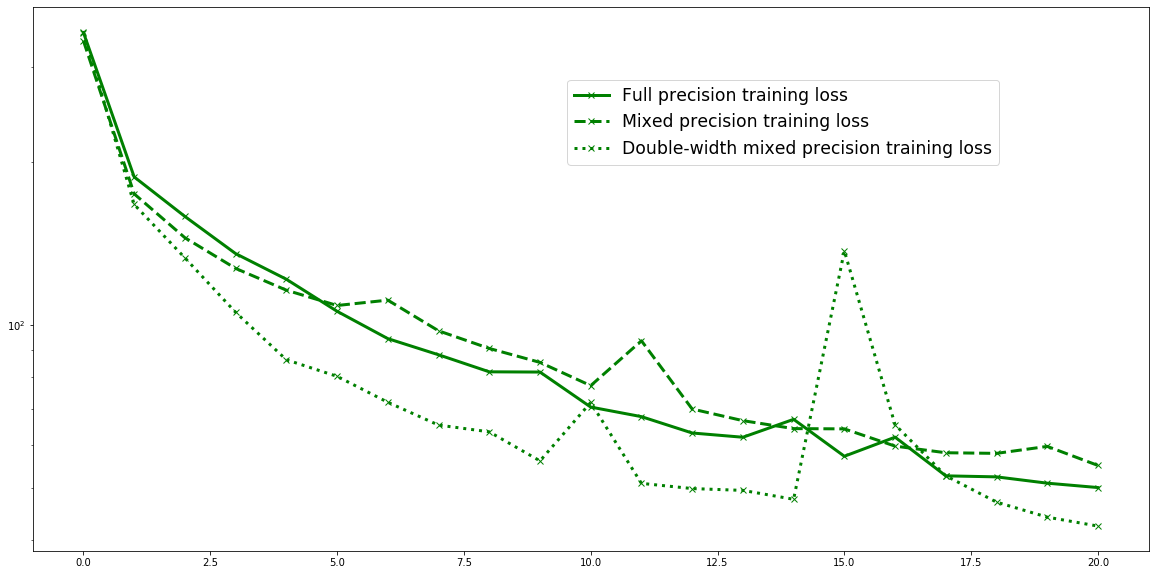

In [25]:
ax = plt.figure(figsize=(20,10))
plt.yscale('log')
plt.plot(full_train_loss_vec, 'gx-', linewidth=3)
plt.plot(mixed_train_loss_vec, 'gx--', linewidth=3)
plt.plot(mixed_wide_train_loss_vec, 'gx:', linewidth=3)
ax.legend(['Full precision training loss', 'Mixed precision training loss', 'Double-width mixed precision training loss'], bbox_to_anchor=(0.7, 0.7), fontsize='xx-large', fancybox=True)

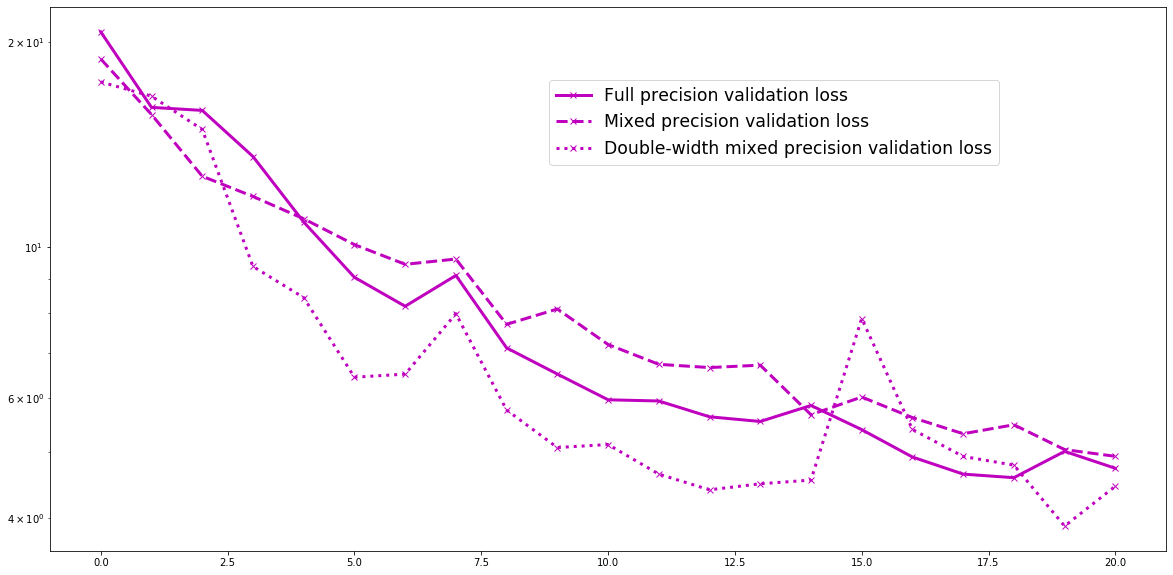

In [28]:
ax = plt.figure(figsize=(20,10))
plt.yscale('log')
plt.plot(full_val_loss_vec, 'mx-', linewidth=3)
plt.plot(mixed_val_loss_vec, 'mx--', linewidth=3)
plt.plot(mixed_wide_val_loss_vec, 'mx:', linewidth=3)
ax.legend(['Full precision validation loss', 'Mixed precision validation loss', 'Double-width mixed precision validation loss'], bbox_to_anchor=(0.7, 0.7), fontsize='xx-large', fancybox=True)

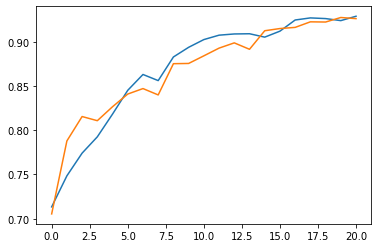

In [38]:
plt.plot(full_val_pur)
plt.plot(mixed_val_pur)

### Memory Report

In [5]:
print(torch.cuda.memory_summary(device=device, abbreviated=True))

|===========================================================================|
|                  PyTorch CUDA memory summary, device ID 0                 |
|---------------------------------------------------------------------------|
|            CUDA OOMs: 0            |        cudaMalloc retries: 0         |
|===========================================================================|
|        Metric         | Cur Usage  | Peak Usage | Tot Alloc  | Tot Freed  |
|---------------------------------------------------------------------------|
| Allocated memory      |       0 B  |       0 B  |       0 B  |       0 B  |
|---------------------------------------------------------------------------|
| Active memory         |       0 B  |       0 B  |       0 B  |       0 B  |
|---------------------------------------------------------------------------|
| GPU reserved memory   |       0 B  |       0 B  |       0 B  |       0 B  |
|---------------------------------------------------------------

In [4]:
torch.cuda.reset_max_memory_cached(device=device)

In [6]:
# torch.cuda.empty_cache()
print(torch.cuda.memory_allocated(device=device)/(1024**2), "MB")

0.0 MB


### Test Batch Memory

In [5]:
gnn_train_dataset[0]

Data(e=[2, 179362], emb=[22780, 8], layers=[22780], pid=[22780], true_edges=[22302, 2], x=[22780, 3], y=[179362])

In [27]:
%%time
model.eval()
with torch.no_grad():
    for i, batch in enumerate(gnn_train_loader):            
#             print(batch)
            data = batch.to(device)
            pred = model(data.x, data.edge_index.int())
            if(i%100==0): print(i, "samples evaluated")

0 samples evaluated
CPU times: user 31.3 s, sys: 11.4 s, total: 42.7 s
Wall time: 43.7 s
